### Import libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

### Create dataset

In [2]:
# Load the CSV file
data = pd.read_csv('circles_data.csv')

In [3]:
# Normalize the input and output data
scaler_inputs = MinMaxScaler()
scaler_outputs = MinMaxScaler()
data.iloc[:, :10] = scaler_inputs.fit_transform(data.iloc[:, :10])  # Normalize inputs
data.iloc[:, 10:] = scaler_outputs.fit_transform(data.iloc[:, 10:])  # Normalize outputs

In [4]:
# Prepare the dataset class
class CircleDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        # Input: First 10 values (x1, y1, ..., x5, y5)
        inputs = torch.tensor(row[:10].values, dtype=torch.float32)
        # Output: Last 12 values (X1, Y1, R1, ..., X4, Y4, R4)
        outputs = row[10:].values.reshape(4, 3)
        outputs = outputs[np.argsort(outputs[:, 2])]  # Sort by radius (R)
        targets = torch.tensor(outputs.flatten(), dtype=torch.float32)
        return inputs, targets

In [5]:
# Split the data into training, validation, and test sets
full_dataset = CircleDataset(data)
train_size = int(0.7 * len(full_dataset))
val_size = int(0.2 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### Define the neural netwrok model

In [6]:
class CircleNet(nn.Module):
    def __init__(self):
        super(CircleNet, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(10, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 12)
        )
    def forward(self, x):
        return self.network(x)


In [7]:
# Instantiate the model, define the loss function and optimizer
model = CircleNet()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Training

In [8]:
from tqdm import tqdm

# Training loop
train_losses = []
val_losses = []

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=50):
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        with tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch") as t:
            for inputs, targets in t:
                optimizer.zero_grad()
                outputs = model(inputs)
                
                # Sort predicted outputs and targets by radius for proper loss calculation
                outputs = outputs.view(-1, 4, 3)
                outputs_sorted = outputs[torch.argsort(outputs[:, :, 2], dim=1)]
                targets = targets.view(-1, 4, 3)
                targets_sorted = targets[torch.argsort(targets[:, :, 2], dim=1)]
                
                # Calculate loss
                loss = criterion(outputs_sorted, targets_sorted)
                loss.backward()
                optimizer.step()
                train_loss += loss.item() * inputs.size(0)
                t.set_postfix(train_loss=train_loss / len(train_loader.dataset))

        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                
                # Sort predicted outputs and targets by radius for validation
                outputs = outputs.view(-1, 4, 3)
                outputs_sorted = outputs[torch.argsort(outputs[:, :, 2], dim=1)]
                targets = targets.view(-1, 4, 3)
                targets_sorted = targets[torch.argsort(targets[:, :, 2], dim=1)]
                
                loss = criterion(outputs_sorted, targets_sorted)
                val_loss += loss.item() * inputs.size(0)

        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")


In [9]:
# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, epochs=100)

Epoch 1/100: 100%|██████████| 2188/2188 [00:29<00:00, 74.09batch/s, train_loss=0.00899]


Epoch 1/100, Train Loss: 0.0090, Validation Loss: 0.0031


Epoch 2/100: 100%|██████████| 2188/2188 [00:33<00:00, 66.03batch/s, train_loss=0.00328]


Epoch 2/100, Train Loss: 0.0033, Validation Loss: 0.0028


Epoch 3/100: 100%|██████████| 2188/2188 [00:33<00:00, 65.69batch/s, train_loss=0.00275]


Epoch 3/100, Train Loss: 0.0027, Validation Loss: 0.0023


Epoch 4/100: 100%|██████████| 2188/2188 [00:33<00:00, 66.12batch/s, train_loss=0.00234]


Epoch 4/100, Train Loss: 0.0023, Validation Loss: 0.0021


Epoch 5/100: 100%|██████████| 2188/2188 [00:33<00:00, 66.10batch/s, train_loss=0.00218]


Epoch 5/100, Train Loss: 0.0022, Validation Loss: 0.0020


Epoch 6/100: 100%|██████████| 2188/2188 [00:32<00:00, 67.96batch/s, train_loss=0.00205] 


Epoch 6/100, Train Loss: 0.0020, Validation Loss: 0.0019


Epoch 7/100: 100%|██████████| 2188/2188 [00:32<00:00, 67.73batch/s, train_loss=0.00201] 


Epoch 7/100, Train Loss: 0.0020, Validation Loss: 0.0019


Epoch 8/100: 100%|██████████| 2188/2188 [00:23<00:00, 91.33batch/s, train_loss=0.00201] 


Epoch 8/100, Train Loss: 0.0020, Validation Loss: 0.0019


Epoch 9/100: 100%|██████████| 2188/2188 [00:26<00:00, 81.28batch/s, train_loss=0.002]   


Epoch 9/100, Train Loss: 0.0020, Validation Loss: 0.0018


Epoch 10/100: 100%|██████████| 2188/2188 [00:27<00:00, 78.78batch/s, train_loss=0.00191] 


Epoch 10/100, Train Loss: 0.0019, Validation Loss: 0.0019


Epoch 11/100: 100%|██████████| 2188/2188 [00:27<00:00, 78.56batch/s, train_loss=0.00195] 


Epoch 11/100, Train Loss: 0.0019, Validation Loss: 0.0018


Epoch 12/100: 100%|██████████| 2188/2188 [00:27<00:00, 79.24batch/s, train_loss=0.00189] 


Epoch 12/100, Train Loss: 0.0019, Validation Loss: 0.0018


Epoch 13/100: 100%|██████████| 2188/2188 [00:28<00:00, 76.41batch/s, train_loss=0.00186] 


Epoch 13/100, Train Loss: 0.0019, Validation Loss: 0.0018


Epoch 14/100: 100%|██████████| 2188/2188 [00:28<00:00, 76.01batch/s, train_loss=0.0018]  


Epoch 14/100, Train Loss: 0.0018, Validation Loss: 0.0017


Epoch 15/100: 100%|██████████| 2188/2188 [00:29<00:00, 75.01batch/s, train_loss=0.00184] 


Epoch 15/100, Train Loss: 0.0018, Validation Loss: 0.0019


Epoch 16/100: 100%|██████████| 2188/2188 [00:34<00:00, 63.62batch/s, train_loss=0.00178] 


Epoch 16/100, Train Loss: 0.0018, Validation Loss: 0.0017


Epoch 17/100: 100%|██████████| 2188/2188 [00:32<00:00, 66.61batch/s, train_loss=0.00178] 


Epoch 17/100, Train Loss: 0.0018, Validation Loss: 0.0018


Epoch 18/100: 100%|██████████| 2188/2188 [00:27<00:00, 78.48batch/s, train_loss=0.00175] 


Epoch 18/100, Train Loss: 0.0017, Validation Loss: 0.0017


Epoch 19/100: 100%|██████████| 2188/2188 [00:28<00:00, 77.26batch/s, train_loss=0.00174] 


Epoch 19/100, Train Loss: 0.0017, Validation Loss: 0.0017


Epoch 20/100: 100%|██████████| 2188/2188 [00:28<00:00, 76.55batch/s, train_loss=0.00178] 


Epoch 20/100, Train Loss: 0.0018, Validation Loss: 0.0017


Epoch 21/100: 100%|██████████| 2188/2188 [00:28<00:00, 77.38batch/s, train_loss=0.00173] 


Epoch 21/100, Train Loss: 0.0017, Validation Loss: 0.0017


Epoch 22/100: 100%|██████████| 2188/2188 [00:28<00:00, 77.34batch/s, train_loss=0.00174] 


Epoch 22/100, Train Loss: 0.0017, Validation Loss: 0.0016


Epoch 23/100: 100%|██████████| 2188/2188 [00:27<00:00, 78.68batch/s, train_loss=0.00171] 


Epoch 23/100, Train Loss: 0.0017, Validation Loss: 0.0016


Epoch 24/100: 100%|██████████| 2188/2188 [00:27<00:00, 78.90batch/s, train_loss=0.00171] 


Epoch 24/100, Train Loss: 0.0017, Validation Loss: 0.0016


Epoch 25/100: 100%|██████████| 2188/2188 [00:28<00:00, 77.97batch/s, train_loss=0.00166] 


Epoch 25/100, Train Loss: 0.0017, Validation Loss: 0.0016


Epoch 26/100: 100%|██████████| 2188/2188 [00:27<00:00, 78.19batch/s, train_loss=0.00169] 


Epoch 26/100, Train Loss: 0.0017, Validation Loss: 0.0016


Epoch 27/100: 100%|██████████| 2188/2188 [00:28<00:00, 76.26batch/s, train_loss=0.00169] 


Epoch 27/100, Train Loss: 0.0017, Validation Loss: 0.0016


Epoch 28/100: 100%|██████████| 2188/2188 [00:28<00:00, 77.08batch/s, train_loss=0.00169] 


Epoch 28/100, Train Loss: 0.0017, Validation Loss: 0.0016


Epoch 29/100: 100%|██████████| 2188/2188 [00:28<00:00, 76.85batch/s, train_loss=0.0017]  


Epoch 29/100, Train Loss: 0.0017, Validation Loss: 0.0015


Epoch 30/100: 100%|██████████| 2188/2188 [00:28<00:00, 76.95batch/s, train_loss=0.00167] 


Epoch 30/100, Train Loss: 0.0017, Validation Loss: 0.0016


Epoch 31/100: 100%|██████████| 2188/2188 [00:28<00:00, 76.21batch/s, train_loss=0.00167] 


Epoch 31/100, Train Loss: 0.0017, Validation Loss: 0.0015


Epoch 32/100: 100%|██████████| 2188/2188 [00:28<00:00, 76.03batch/s, train_loss=0.00162] 


Epoch 32/100, Train Loss: 0.0016, Validation Loss: 0.0015


Epoch 33/100: 100%|██████████| 2188/2188 [00:28<00:00, 76.88batch/s, train_loss=0.00164] 


Epoch 33/100, Train Loss: 0.0016, Validation Loss: 0.0016


Epoch 34/100: 100%|██████████| 2188/2188 [00:28<00:00, 76.66batch/s, train_loss=0.00163] 


Epoch 34/100, Train Loss: 0.0016, Validation Loss: 0.0015


Epoch 35/100: 100%|██████████| 2188/2188 [00:28<00:00, 77.17batch/s, train_loss=0.0017]  


Epoch 35/100, Train Loss: 0.0017, Validation Loss: 0.0015


Epoch 36/100: 100%|██████████| 2188/2188 [00:28<00:00, 77.45batch/s, train_loss=0.00165] 


Epoch 36/100, Train Loss: 0.0017, Validation Loss: 0.0015


Epoch 37/100: 100%|██████████| 2188/2188 [00:28<00:00, 77.15batch/s, train_loss=0.00167] 


Epoch 37/100, Train Loss: 0.0017, Validation Loss: 0.0018


Epoch 38/100: 100%|██████████| 2188/2188 [00:28<00:00, 76.58batch/s, train_loss=0.00167] 


Epoch 38/100, Train Loss: 0.0017, Validation Loss: 0.0016


Epoch 39/100: 100%|██████████| 2188/2188 [00:28<00:00, 76.64batch/s, train_loss=0.00165] 


Epoch 39/100, Train Loss: 0.0016, Validation Loss: 0.0015


Epoch 40/100: 100%|██████████| 2188/2188 [00:28<00:00, 76.68batch/s, train_loss=0.00161] 


Epoch 40/100, Train Loss: 0.0016, Validation Loss: 0.0016


Epoch 41/100: 100%|██████████| 2188/2188 [00:28<00:00, 75.55batch/s, train_loss=0.00161] 


Epoch 41/100, Train Loss: 0.0016, Validation Loss: 0.0015


Epoch 42/100: 100%|██████████| 2188/2188 [00:28<00:00, 76.62batch/s, train_loss=0.00162] 


Epoch 42/100, Train Loss: 0.0016, Validation Loss: 0.0016


Epoch 43/100: 100%|██████████| 2188/2188 [00:28<00:00, 76.68batch/s, train_loss=0.00166] 


Epoch 43/100, Train Loss: 0.0017, Validation Loss: 0.0015


Epoch 44/100: 100%|██████████| 2188/2188 [00:28<00:00, 75.62batch/s, train_loss=0.00162] 


Epoch 44/100, Train Loss: 0.0016, Validation Loss: 0.0015


Epoch 45/100: 100%|██████████| 2188/2188 [00:29<00:00, 74.26batch/s, train_loss=0.00163] 


Epoch 45/100, Train Loss: 0.0016, Validation Loss: 0.0015


Epoch 46/100: 100%|██████████| 2188/2188 [00:28<00:00, 75.96batch/s, train_loss=0.00163] 


Epoch 46/100, Train Loss: 0.0016, Validation Loss: 0.0015


Epoch 47/100: 100%|██████████| 2188/2188 [00:29<00:00, 75.11batch/s, train_loss=0.00162] 


Epoch 47/100, Train Loss: 0.0016, Validation Loss: 0.0015


Epoch 48/100: 100%|██████████| 2188/2188 [00:29<00:00, 74.87batch/s, train_loss=0.00168] 


Epoch 48/100, Train Loss: 0.0017, Validation Loss: 0.0015


Epoch 49/100: 100%|██████████| 2188/2188 [00:28<00:00, 75.61batch/s, train_loss=0.00162] 


Epoch 49/100, Train Loss: 0.0016, Validation Loss: 0.0015


Epoch 50/100: 100%|██████████| 2188/2188 [00:29<00:00, 74.63batch/s, train_loss=0.00159] 


Epoch 50/100, Train Loss: 0.0016, Validation Loss: 0.0015


Epoch 51/100: 100%|██████████| 2188/2188 [00:29<00:00, 73.15batch/s, train_loss=0.00162] 


Epoch 51/100, Train Loss: 0.0016, Validation Loss: 0.0015


Epoch 52/100: 100%|██████████| 2188/2188 [00:29<00:00, 74.53batch/s, train_loss=0.00169] 


Epoch 52/100, Train Loss: 0.0017, Validation Loss: 0.0017


Epoch 53/100: 100%|██████████| 2188/2188 [00:29<00:00, 74.15batch/s, train_loss=0.00163] 


Epoch 53/100, Train Loss: 0.0016, Validation Loss: 0.0015


Epoch 54/100: 100%|██████████| 2188/2188 [00:29<00:00, 73.89batch/s, train_loss=0.00166] 


Epoch 54/100, Train Loss: 0.0017, Validation Loss: 0.0015


Epoch 55/100: 100%|██████████| 2188/2188 [00:29<00:00, 73.73batch/s, train_loss=0.00162] 


Epoch 55/100, Train Loss: 0.0016, Validation Loss: 0.0015


Epoch 56/100: 100%|██████████| 2188/2188 [00:29<00:00, 74.08batch/s, train_loss=0.00159] 


Epoch 56/100, Train Loss: 0.0016, Validation Loss: 0.0016


Epoch 57/100: 100%|██████████| 2188/2188 [00:29<00:00, 73.99batch/s, train_loss=0.00164] 


Epoch 57/100, Train Loss: 0.0016, Validation Loss: 0.0015


Epoch 58/100: 100%|██████████| 2188/2188 [00:29<00:00, 73.84batch/s, train_loss=0.00162] 


Epoch 58/100, Train Loss: 0.0016, Validation Loss: 0.0015


Epoch 59/100: 100%|██████████| 2188/2188 [00:29<00:00, 73.90batch/s, train_loss=0.00158] 


Epoch 59/100, Train Loss: 0.0016, Validation Loss: 0.0015


Epoch 60/100: 100%|██████████| 2188/2188 [00:29<00:00, 73.94batch/s, train_loss=0.00166] 


Epoch 60/100, Train Loss: 0.0017, Validation Loss: 0.0016


Epoch 61/100: 100%|██████████| 2188/2188 [00:29<00:00, 73.38batch/s, train_loss=0.00159] 


Epoch 61/100, Train Loss: 0.0016, Validation Loss: 0.0015


Epoch 62/100: 100%|██████████| 2188/2188 [00:30<00:00, 72.63batch/s, train_loss=0.00158] 


Epoch 62/100, Train Loss: 0.0016, Validation Loss: 0.0014


Epoch 63/100: 100%|██████████| 2188/2188 [00:29<00:00, 73.33batch/s, train_loss=0.00163] 


Epoch 63/100, Train Loss: 0.0016, Validation Loss: 0.0015


Epoch 64/100: 100%|██████████| 2188/2188 [00:30<00:00, 72.92batch/s, train_loss=0.00167] 


Epoch 64/100, Train Loss: 0.0017, Validation Loss: 0.0015


Epoch 65/100: 100%|██████████| 2188/2188 [00:29<00:00, 73.30batch/s, train_loss=0.00163] 


Epoch 65/100, Train Loss: 0.0016, Validation Loss: 0.0015


Epoch 66/100: 100%|██████████| 2188/2188 [00:29<00:00, 73.17batch/s, train_loss=0.00161] 


Epoch 66/100, Train Loss: 0.0016, Validation Loss: 0.0015


Epoch 67/100: 100%|██████████| 2188/2188 [00:29<00:00, 73.12batch/s, train_loss=0.00159] 


Epoch 67/100, Train Loss: 0.0016, Validation Loss: 0.0015


Epoch 68/100: 100%|██████████| 2188/2188 [00:30<00:00, 72.92batch/s, train_loss=0.00162] 


Epoch 68/100, Train Loss: 0.0016, Validation Loss: 0.0015


Epoch 69/100: 100%|██████████| 2188/2188 [00:30<00:00, 72.77batch/s, train_loss=0.0016]  


Epoch 69/100, Train Loss: 0.0016, Validation Loss: 0.0017


Epoch 70/100: 100%|██████████| 2188/2188 [00:30<00:00, 72.26batch/s, train_loss=0.00162] 


Epoch 70/100, Train Loss: 0.0016, Validation Loss: 0.0015


Epoch 71/100: 100%|██████████| 2188/2188 [00:30<00:00, 72.78batch/s, train_loss=0.00159] 


Epoch 71/100, Train Loss: 0.0016, Validation Loss: 0.0015


Epoch 72/100: 100%|██████████| 2188/2188 [00:32<00:00, 67.52batch/s, train_loss=0.00166] 


Epoch 72/100, Train Loss: 0.0017, Validation Loss: 0.0015


Epoch 73/100: 100%|██████████| 2188/2188 [00:32<00:00, 66.39batch/s, train_loss=0.00157] 


Epoch 73/100, Train Loss: 0.0016, Validation Loss: 0.0015


Epoch 74/100: 100%|██████████| 2188/2188 [00:31<00:00, 70.08batch/s, train_loss=0.00156] 


Epoch 74/100, Train Loss: 0.0016, Validation Loss: 0.0014


Epoch 75/100: 100%|██████████| 2188/2188 [00:31<00:00, 70.09batch/s, train_loss=0.00159] 


Epoch 75/100, Train Loss: 0.0016, Validation Loss: 0.0015


Epoch 76/100: 100%|██████████| 2188/2188 [00:31<00:00, 69.95batch/s, train_loss=0.00157] 


Epoch 76/100, Train Loss: 0.0016, Validation Loss: 0.0015


Epoch 77/100: 100%|██████████| 2188/2188 [00:31<00:00, 70.09batch/s, train_loss=0.00158] 


Epoch 77/100, Train Loss: 0.0016, Validation Loss: 0.0015


Epoch 78/100: 100%|██████████| 2188/2188 [00:31<00:00, 70.00batch/s, train_loss=0.00156] 


Epoch 78/100, Train Loss: 0.0016, Validation Loss: 0.0015


Epoch 79/100: 100%|██████████| 2188/2188 [00:31<00:00, 70.27batch/s, train_loss=0.00158] 


Epoch 79/100, Train Loss: 0.0016, Validation Loss: 0.0015


Epoch 80/100: 100%|██████████| 2188/2188 [00:31<00:00, 69.12batch/s, train_loss=0.00155] 


Epoch 80/100, Train Loss: 0.0016, Validation Loss: 0.0015


Epoch 81/100: 100%|██████████| 2188/2188 [00:31<00:00, 69.51batch/s, train_loss=0.00158] 


Epoch 81/100, Train Loss: 0.0016, Validation Loss: 0.0015


Epoch 82/100: 100%|██████████| 2188/2188 [00:31<00:00, 69.47batch/s, train_loss=0.00159] 


Epoch 82/100, Train Loss: 0.0016, Validation Loss: 0.0016


Epoch 83/100: 100%|██████████| 2188/2188 [00:31<00:00, 68.93batch/s, train_loss=0.00157] 


Epoch 83/100, Train Loss: 0.0016, Validation Loss: 0.0015


Epoch 84/100: 100%|██████████| 2188/2188 [00:30<00:00, 70.62batch/s, train_loss=0.00158] 


Epoch 84/100, Train Loss: 0.0016, Validation Loss: 0.0015


Epoch 85/100: 100%|██████████| 2188/2188 [00:31<00:00, 70.40batch/s, train_loss=0.00159] 


Epoch 85/100, Train Loss: 0.0016, Validation Loss: 0.0015


Epoch 86/100: 100%|██████████| 2188/2188 [00:31<00:00, 70.54batch/s, train_loss=0.00161] 


Epoch 86/100, Train Loss: 0.0016, Validation Loss: 0.0015


Epoch 87/100: 100%|██████████| 2188/2188 [00:31<00:00, 70.22batch/s, train_loss=0.00154] 


Epoch 87/100, Train Loss: 0.0015, Validation Loss: 0.0015


Epoch 88/100: 100%|██████████| 2188/2188 [00:31<00:00, 70.35batch/s, train_loss=0.00159] 


Epoch 88/100, Train Loss: 0.0016, Validation Loss: 0.0014


Epoch 89/100: 100%|██████████| 2188/2188 [00:31<00:00, 70.24batch/s, train_loss=0.00159] 


Epoch 89/100, Train Loss: 0.0016, Validation Loss: 0.0014


Epoch 90/100: 100%|██████████| 2188/2188 [00:31<00:00, 70.23batch/s, train_loss=0.00161] 


Epoch 90/100, Train Loss: 0.0016, Validation Loss: 0.0015


Epoch 91/100: 100%|██████████| 2188/2188 [00:31<00:00, 70.06batch/s, train_loss=0.00158] 


Epoch 91/100, Train Loss: 0.0016, Validation Loss: 0.0015


Epoch 92/100: 100%|██████████| 2188/2188 [00:31<00:00, 70.34batch/s, train_loss=0.00154] 


Epoch 92/100, Train Loss: 0.0015, Validation Loss: 0.0014


Epoch 93/100: 100%|██████████| 2188/2188 [00:31<00:00, 70.13batch/s, train_loss=0.00158] 


Epoch 93/100, Train Loss: 0.0016, Validation Loss: 0.0014


Epoch 94/100: 100%|██████████| 2188/2188 [00:31<00:00, 70.06batch/s, train_loss=0.00157] 


Epoch 94/100, Train Loss: 0.0016, Validation Loss: 0.0015


Epoch 95/100: 100%|██████████| 2188/2188 [00:30<00:00, 70.64batch/s, train_loss=0.00153] 


Epoch 95/100, Train Loss: 0.0015, Validation Loss: 0.0015


Epoch 96/100: 100%|██████████| 2188/2188 [00:31<00:00, 70.00batch/s, train_loss=0.0016]  


Epoch 96/100, Train Loss: 0.0016, Validation Loss: 0.0015


Epoch 97/100: 100%|██████████| 2188/2188 [00:31<00:00, 68.65batch/s, train_loss=0.00162] 


Epoch 97/100, Train Loss: 0.0016, Validation Loss: 0.0015


Epoch 98/100: 100%|██████████| 2188/2188 [00:34<00:00, 64.00batch/s, train_loss=0.00161] 


Epoch 98/100, Train Loss: 0.0016, Validation Loss: 0.0014


Epoch 99/100: 100%|██████████| 2188/2188 [00:34<00:00, 63.66batch/s, train_loss=0.00153] 


Epoch 99/100, Train Loss: 0.0015, Validation Loss: 0.0014


Epoch 100/100: 100%|██████████| 2188/2188 [00:33<00:00, 64.77batch/s, train_loss=0.00156] 


Epoch 100/100, Train Loss: 0.0016, Validation Loss: 0.0014


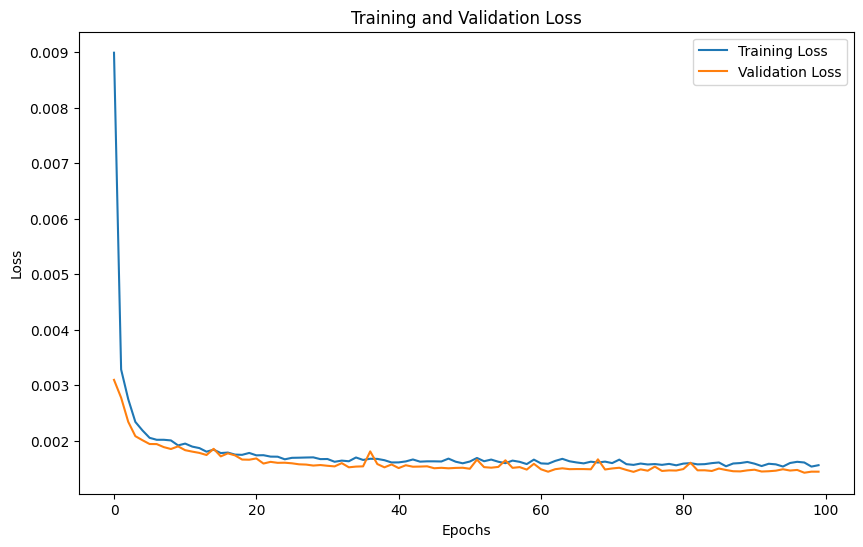

In [10]:
# Plot training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

### Test the model

In [12]:
def evaluate_model(model, test_loader):
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            
            # Sort predicted outputs and targets by radius for testing
            outputs = outputs.view(-1, 4, 3)
            outputs_sorted = outputs[torch.argsort(outputs[:, :, 2], dim=1)]
            targets = targets.view(-1, 4, 3)
            targets_sorted = targets[torch.argsort(targets[:, :, 2], dim=1)]
            
            loss = criterion(outputs_sorted, targets_sorted)
            test_loss += loss.item() * inputs.size(0)

    test_loss /= len(test_loader.dataset)
    print(f"Test Loss: {test_loss:.4f}")

In [ ]:
evaluate_model(model, test_loader)

In [18]:
# Specific input for testing
specific_input = [
    61.74719849728242, 66.0826770542444,
    73.21459488977521, 5.067185075819792,
    66.29152958575784, 73.28946490206675,
    86.30645454313891, 64.34581865715569,
    29.04780471386177, 39.61582050352237
]

desired_output = [
    63.131902209568814, 39.35110116447956, 34.085125470520666,
    63.59603198465599, 38.27647737757573, 34.57417891350714,
    70.92214718817844, 21.313942143061468, 45.69922656925765,
    106.48912108086489, 42.906229348552145, 50.388365370688255
]

# Normalize the specific input for prediction
specific_input_normalized = scaler_inputs.transform([specific_input])
specific_input_tensor = torch.tensor(specific_input_normalized, dtype=torch.float32).unsqueeze(0).squeeze(1)


# Model prediction
model.eval()
with torch.no_grad():
    specific_output = model(specific_input_tensor).numpy().reshape(4, 3)
    specific_output_rescaled = scaler_outputs.inverse_transform(specific_output.reshape(1, -1)).reshape(4, 3)
    
    # Print results without scientific notation using formatting
    #print("Specific Input:", [f"{x:.6f}" for x in specific_input])
    #print("Desired Output (Before Sorting):")
    #for row in np.array(desired_output).reshape(4, 3):
    #    print([f"{x:.6f}" for x in row])
    #print("Predicted Output (Before Sorting):")
    #for row in specific_output_rescaled:
    #    print([f"{x:.6f}" for x in row])
    
    # Sort both outputs by radius (R)
    specific_output_sorted = specific_output_rescaled[np.argsort(specific_output_rescaled[:, 2])]
    desired_output_sorted = np.array(desired_output).reshape(4, 3)[np.argsort(np.array(desired_output).reshape(4, 3)[:, 2])]
    print("Desired Output (After Sorting):")
    for row in desired_output_sorted:
        print([f"{x:.6f}" for x in row])
    print("Predicted Output (After Sorting):")
    for row in specific_output_sorted:
        print([f"{x:.6f}" for x in row])


Desired Output (After Sorting):
['63.131902', '39.351101', '34.085125']
['63.596032', '38.276477', '34.574179']
['70.922147', '21.313942', '45.699227']
['106.489121', '42.906229', '50.388365']
Predicted Output (After Sorting):
['-279.368347', '-297.528564', '3.452319']
['-0.044879', '-193.797409', '5.190537']
['2525.663818', '12918.301758', '1478.805420']
['192430912.000000', '291831840.000000', '32582940.000000']


c:\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
